# Задача

Нам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Требование: довести F1-меру на тестовой выборке до 0.59

Признаки:  

- RowNumber — индекс строки в данных  
- CustomerId — уникальный идентификатор клиента  
- Surname — фамилия  
- CreditScore — кредитный рейтинг  
- Geography — страна проживания  
- Gender — пол  
- Age — возраст  
- Tenure — сколько лет человек является клиентом банка  
- Balance — баланс на счёте  
- NumOfProducts — количество продуктов банка, используемых клиентом  
- HasCrCard — наличие кредитной карты  
- IsActiveMember — активность клиента  
- EstimatedSalary — предполагаемая зарплата  

Целевой признак:  

- Exited — факт ухода клиента  

# Подготовка данных

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import precision_score, recall_score, auc, accuracy_score, roc_auc_score, f1_score,\
classification_report, roc_curve
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings("ignore")

RAND = 22

In [2]:
df = pd.read_csv('Churn.csv')

In [3]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [4]:
df = df.drop('RowNumber', axis=1)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           9091 non-null   float64
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(3), int64(7), object(3)
memory usage: 1015.8+ KB


В нашем датасете 10000 наблюдений. Есть пропущенные значения в столбце Tenure. Это довольно важный признак, поэтому если заполнить его константным значением, то мы сильно исказим наши данные, и модели будут плохо предсказывать

In [6]:
df = df.dropna().reset_index(drop=True)

Целевой признак 'Exited' имеет категориальный тип данных (1 - ушел из банка, 0 - не ушел). Значит мы имеем дело с классификацией - исходя из признаков должны предсказать факт ухода клиента от банка. Сначала посмотрим на баланс классов

0    0.796062
1    0.203938
Name: Exited, dtype: float64


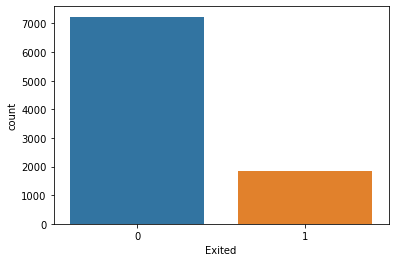

In [7]:
print(df['Exited'].value_counts(normalize=True))
sns.countplot(x='Exited', data=df);

В датесете присутствует дисбаланс классов, при обучении модели это стоит учитывать

Отделим целевой признак

In [8]:
X = df.drop(['CustomerId', 'Surname', 'Exited'], axis=1)
y = df['Exited']

In [9]:
X.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10


Для корректной работы алгоритмов нужно привести все категориальные признаки в численный тип данных

In [10]:
X = pd.get_dummies(X, drop_first=True)
X.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,1,0


Посмотрим на корреляцию признаков

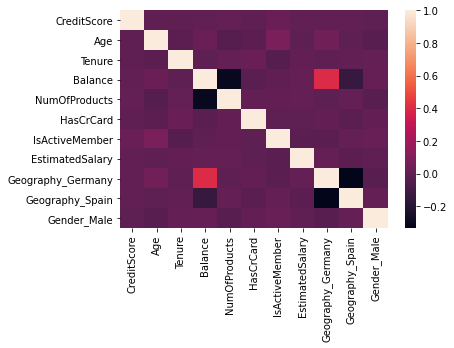

In [11]:
sns.heatmap(X.corr())
plt.show()

Сильной связи между признаками нет. Это будет плюсом в обучении моделей

Признаки имеют разные масштабы значений. Из-за этого веса у линейных моделей будет сильно различаться. Чтобы избежать этого нам нужно стандартизировать численные значения признаков. Но сначала разделим данные на обучающую и тестовую выборки

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, shuffle=True, random_state=RAND)

In [13]:
X_train.shape, X_test.shape

((6363, 11), (2728, 11))

In [14]:
numeric = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']

In [15]:
scaler = StandardScaler()
scaler.fit(X_train[numeric]) 

StandardScaler()

In [16]:
X_train[numeric] = scaler.transform(X_train[numeric])
X_test[numeric] = scaler.transform(X_test[numeric])

In [17]:
X_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
8723,1.241726,-0.759917,3.0,1.256240,2,1,1,1.497281,0,0,1
1500,1.272761,1.224806,4.0,-1.222541,1,0,1,0.767497,0,0,1
5739,-2.068749,-0.948939,7.0,0.651159,1,1,1,-0.983125,0,0,1
7663,0.134786,-0.570896,8.0,0.324528,1,1,1,-1.098228,0,1,0
4696,0.455488,-0.098343,1.0,-1.222541,2,0,1,0.989207,0,0,1


In [18]:
X_test.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
8776,0.258928,-0.003832,6.0,-1.222541,2,0,0,-0.288349,0,0,0
8795,-0.620417,-0.287364,1.0,-1.222541,2,1,0,-0.889252,0,0,1
1947,0.103750,-0.381875,6.0,0.388472,1,1,0,-1.405521,0,0,0
3591,-1.189404,0.941274,3.0,-1.222541,1,0,0,-0.664084,0,0,0
3875,-0.279024,0.090679,5.0,0.676559,1,1,0,1.615628,0,0,1


Теперь данные готовы для моделирования

# Моделирование

## Baseline

В этот датафрейм будем хранить метрики моделей

In [19]:
metrics = pd.DataFrame(index=['accuracy', 'roc-auc', 'precision', 'recall', 'f1'])

### Logistic Regression

In [20]:
model = LogisticRegression(class_weight='balanced', random_state=RAND)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_score = model.predict_proba(X_test)[:,1]

In [21]:
print('accuracy:', accuracy_score(y_test, y_pred))
print('roc-auc:', roc_auc_score(y_test, y_score))
print('precision:', precision_score(y_test, y_pred))
print('recall:', recall_score(y_test, y_pred))
print('f1:', f1_score(y_test, y_pred))

accuracy: 0.7129765395894428
roc-auc: 0.7736620096188243
precision: 0.3850050658561297
recall: 0.6834532374100719
f1: 0.49254698639014904


Если банку выгоднее пресказать лучше больше "плохих" клиентов, чтобы избежать большие потери, то лучше ориентироваться еще на метрику recall, если будем сравнивать в baseline и другими алгоритмами, иначе precision.

In [22]:
metrics['Baseline_LR'] = [accuracy_score(y_test, y_pred),
                          roc_auc_score(y_test, y_score),
                          precision_score(y_test, y_pred),
                          recall_score(y_test, y_pred),
                          f1_score(y_test, y_pred)]
metrics

,Baseline_LR
accuracy,0.712977
roc-auc,0.773662
precision,0.385005
recall,0.683453
f1,0.492547


### Random Forest Classifier

In [23]:
model = RandomForestClassifier(class_weight = 'balanced', random_state=RAND)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_score = model.predict_proba(X_test)[:,1]

In [24]:
metrics['Baseline_RFC'] = [accuracy_score(y_test, y_pred),
                          roc_auc_score(y_test, y_score),
                          precision_score(y_test, y_pred),
                          recall_score(y_test, y_pred),
                          f1_score(y_test, y_pred)]
metrics

,Baseline_LR,Baseline_RFC
accuracy,0.712977,0.855572
roc-auc,0.773662,0.860015
precision,0.385005,0.761290
recall,0.683453,0.424460
f1,0.492547,0.545035


### LightGBM

In [25]:
model = LGBMClassifier(class_weight = 'balanced', random_state=RAND)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_score = model.predict_proba(X_test)[:,1]

In [26]:
metrics['Baseline_LGBM'] = [accuracy_score(y_test, y_pred),
                          roc_auc_score(y_test, y_score),
                          precision_score(y_test, y_pred),
                          recall_score(y_test, y_pred),
                          f1_score(y_test, y_pred)]
metrics

,Baseline_LR,Baseline_RFC,Baseline_LGBM
accuracy,0.712977,0.855572,0.822581
roc-auc,0.773662,0.860015,0.859060
precision,0.385005,0.761290,0.551873
recall,0.683453,0.424460,0.688849
f1,0.492547,0.545035,0.612800


Без подбора никаких параметров, лучше всех себя показал алгоритм градиентного бустинга. F1-мера составила 0.61, площадь под ROC-кривой 0.86

## Подбор гиперпараметров

### Logistic Regression

In [27]:
parameters_grid = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': np.linspace(1, 1000, num=5),
    'solver': ['sag', 'saga', 'lbfgs'],
    'l1_ratio': [0.25, 0.5, 0.75],
    'max_iter': np.arange(100, 500, 100)
}

model = LogisticRegression(class_weight='balanced', random_state=RAND)
cv = StratifiedKFold(n_splits=3, shuffle=True)
grid_cv = GridSearchCV(model, parameters_grid, scoring='f1', cv=cv, verbose=2)

In [28]:
# grid_cv.fit(X_train, y_train)

In [29]:
# grid_cv.best_params_

# {'C': 1.0, 'l1_ratio': 0.25, 'max_iter': 100, 'penalty': 'elasticnet', 'solver': 'saga'}

In [30]:
best_params = {'C': 1.0, 
               'l1_ratio': 0.25,
               'max_iter': 100, 
               'penalty': 'l1', 
               'solver': 'saga'}

In [31]:
model = LogisticRegression(**best_params, class_weight='balanced', random_state=RAND)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_score = model.predict_proba(X_test)[:,1]

In [32]:
metrics['Grid_LR'] = [accuracy_score(y_test, y_pred),
                      roc_auc_score(y_test, y_score),
                      precision_score(y_test, y_pred),
                      recall_score(y_test, y_pred),
                      f1_score(y_test, y_pred)]
metrics

,Baseline_LR,Baseline_RFC,Baseline_LGBM,Grid_LR
accuracy,0.712977,0.855572,0.822581,0.712977
roc-auc,0.773662,0.860015,0.859060,0.773710
precision,0.385005,0.761290,0.551873,0.385238
recall,0.683453,0.424460,0.688849,0.685252
f1,0.492547,0.545035,0.612800,0.493204


Качество не улучшилось

### Random Forest Classifier

In [33]:
parameters_grid = {
    'max_depth': [5, 8, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5]
}

model = RandomForestClassifier(class_weight='balanced', random_state=RAND)
cv = StratifiedKFold(n_splits=3, shuffle=True)
grid_cv = GridSearchCV(model, parameters_grid, scoring='f1', cv=cv, verbose=2)

In [34]:
# grid_cv.fit(X_train, y_train)

In [35]:
# grid_cv.best_params_

# {'max_depth': 15, 'min_samples_split': 10, 'min_samples_leaf': 2}

In [36]:
parameters_grid = {
    'max_depth': [10, 15, 20],
    'min_samples_split': [10, 15, 20],
    'min_samples_leaf': [2, 3, 4]
}

model = RandomForestClassifier(class_weight='balanced', random_state=RAND)
cv = StratifiedKFold(n_splits=3, shuffle=True)
grid_cv = GridSearchCV(model, parameters_grid, scoring='f1', cv=cv, verbose=2)

In [37]:
# grid_cv.fit(X_train, y_train)

In [38]:
# grid_cv.best_params_

# {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 15}

In [39]:
parameters_grid = {
    'max_depth': [18, 20, 22, 24],
    'min_samples_split': [10, 15, 20]
}

model = RandomForestClassifier(min_samples_leaf=2, class_weight='balanced', random_state=RAND)
cv = StratifiedKFold(n_splits=3, shuffle=True)
grid_cv = GridSearchCV(model, parameters_grid, scoring='f1', cv=cv, verbose=2)

In [40]:
# grid_cv.fit(X_train, y_train)

In [41]:
# grid_cv.best_params_

# {'max_depth': 18, 'min_samples_split': 10}

In [42]:
parameters_grid = {
    'max_depth': [16, 17, 18, 19],
    'min_samples_split': [8, 10, 12]
}

model = RandomForestClassifier(min_samples_leaf=2, class_weight='balanced', random_state=RAND)
cv = StratifiedKFold(n_splits=3, shuffle=True)
grid_cv = GridSearchCV(model, parameters_grid, scoring='f1', cv=cv, verbose=2)

In [43]:
# grid_cv.fit(X_train, y_train)

In [44]:
# grid_cv.best_params_

# {'max_depth': 19, 'min_samples_split': 12}

In [45]:
best_params = {'max_depth': 19, 
               'min_samples_leaf': 2, 
               'min_samples_split': 12}

In [46]:
model = RandomForestClassifier(**best_params, class_weight='balanced', random_state=RAND)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_score = model.predict_proba(X_test)[:,1]

In [47]:
metrics['Grid_RFC'] = [accuracy_score(y_test, y_pred),
                      roc_auc_score(y_test, y_score),
                      precision_score(y_test, y_pred),
                      recall_score(y_test, y_pred),
                      f1_score(y_test, y_pred)]
metrics

,Baseline_LR,Baseline_RFC,Baseline_LGBM,Grid_LR,Grid_RFC
accuracy,0.712977,0.855572,0.822581,0.712977,0.851173
roc-auc,0.773662,0.860015,0.859060,0.773710,0.862714
precision,0.385005,0.761290,0.551873,0.385238,0.644788
recall,0.683453,0.424460,0.688849,0.685252,0.600719
f1,0.492547,0.545035,0.612800,0.493204,0.621974


Увеличили f1-меру, увеличив значение полноты

### LightGBM

In [48]:
parameters_grid = {
    'max_depth': [5, 8, 15],
    'num_leaves': [50, 100, 150],
    'min_data_in_leaf': [10, 20, 30]
}

model = LGBMClassifier(class_weight='balanced', random_state=RAND)
cv = StratifiedKFold(n_splits=3, shuffle=True)
grid_cv = GridSearchCV(model, parameters_grid, scoring='f1', cv=cv, verbose=2)

In [49]:
# grid_cv.fit(X_train, y_train)

In [50]:
# grid_cv.best_params_

# {'max_depth': 8, 'min_data_in_leaf': 20, 'num_leaves': 100}

In [51]:
parameters_grid = {
    'max_depth': [6, 8, 10],
    'num_leaves': [80, 100, 120],
    'min_data_in_leaf': [15, 20, 25]
}

model = LGBMClassifier(class_weight='balanced', random_state=RAND)
cv = StratifiedKFold(n_splits=3, shuffle=True)
grid_cv = GridSearchCV(model, parameters_grid, scoring='f1', cv=cv, verbose=2)

In [52]:
# grid_cv.fit(X_train, y_train)

In [53]:
# grid_cv.best_params_

# {'max_depth': 10, 'min_data_in_leaf': 25, 'num_leaves': 80}

In [54]:
parameters_grid = {
    'max_depth': [9, 10, 12],
    'num_leaves': [70, 80, 90],
    'min_data_in_leaf': [22, 25, 28]
}

model = LGBMClassifier(class_weight='balanced', random_state=RAND)
cv = StratifiedKFold(n_splits=3, shuffle=True)
grid_cv = GridSearchCV(model, parameters_grid, scoring='f1', cv=cv, verbose=2)

In [55]:
# grid_cv.fit(X_train, y_train)

In [56]:
# grid_cv.best_params_

# {'max_depth': 10, 'min_data_in_leaf': 28, 'num_leaves': 90}

In [57]:
best_params = {'max_depth': 10, 
               'min_data_in_leaf': 28, 
               'num_leaves': 90}

In [58]:
model = LGBMClassifier(**best_params, class_weight='balanced', random_state=RAND)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_score = model.predict_proba(X_test)[:,1]

[LightGBM] [Warning] min_data_in_leaf is set=28, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=28


In [59]:
metrics['Grid_LGBM'] = [accuracy_score(y_test, y_pred),
                      roc_auc_score(y_test, y_score),
                      precision_score(y_test, y_pred),
                      recall_score(y_test, y_pred),
                      f1_score(y_test, y_pred)]
metrics

,Baseline_LR,Baseline_RFC,Baseline_LGBM,Grid_LR,Grid_RFC,Grid_LGBM
accuracy,0.712977,0.855572,0.822581,0.712977,0.851173,0.828079
roc-auc,0.773662,0.860015,0.859060,0.773710,0.862714,0.850801
precision,0.385005,0.761290,0.551873,0.385238,0.644788,0.568075
recall,0.683453,0.424460,0.688849,0.685252,0.600719,0.652878
f1,0.492547,0.545035,0.612800,0.493204,0.621974,0.607531


Немного улучшилась полнота, но упало значение точности. Из-за этого f1-мера почти не изменилась

Если банку выгоднее предсказывать как можно больше клиентов, которые уйдут от них, то нужно смотреть на метрику recall. И лучший результат по этой метрике у градиентного бустинга.  
Если банку наоборот выгоднее не ошибиться в выборе клиента, который от них уйдет, то тут уже нужно смотреть на метрику precision. Лучшим по этой метрике оказался алгоритм случайного леса без подобранных параметров.
Наиболее часто смотрят на метрику f1-меры. Так как он сбалансирует выше названные метрики. Тут лучшим оказался случайный лес с подобранными параметрами

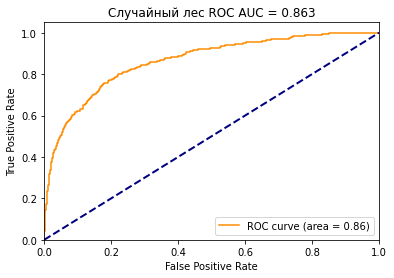

In [60]:
best_params = {'max_depth': 19, 
               'min_samples_leaf': 2, 
               'min_samples_split': 12}

model = RandomForestClassifier(**best_params, class_weight='balanced', random_state=RAND)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
y_score = model.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = roc_curve(y_test, y_score)

roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('Случайный лес ROC AUC = %0.3f' % roc_auc)
plt.legend(loc="lower right")
plt.show()

Площадь под кривой составила 0.86. Это означает что наша модель намного лучше, чем рандомный выбор (пунктирная линия)